In [2]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv("fraud.csv.csv")
df.columns = df.columns.str.strip()

In [4]:
df["Credit_History"] = df["Credit_History"].fillna(0)

In [5]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,0.0,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [6]:
df["ApplicantIncome"] = df["ApplicantIncome"].fillna(0)
df["CoapplicantIncome"] = df["CoapplicantIncome"].fillna(0)
df["LoanAmount"] = df["LoanAmount"].fillna(df["LoanAmount"].median())
df["Loan_Amount_Term"] = df["Loan_Amount_Term"].fillna(df["Loan_Amount_Term"].median())

In [7]:
total_income = df["ApplicantIncome"] + df["CoapplicantIncome"]
ratio = df["LoanAmount"] / (total_income.replace(0, np.nan))  # avoid div by zero
ratio = ratio.fillna(1) 

In [8]:
df["Loan_Status"] = (
    (df["Credit_History"] == 1)
    & (ratio < 0.4)
    & (df["Loan_Amount_Term"] >= 180)
).astype(int)  # 1 = approved, 0 = rejected 
print("Synthetic target distribution:\n", df["Loan_Status"].value_counts())


Synthetic target distribution:
 Loan_Status
1    272
0     95
Name: count, dtype: int64


In [9]:
X = df.drop(columns=["Loan_ID", "Loan_Status"], errors="ignore")
y = df["Loan_Status"]

In [10]:
numeric_cols = [
    "ApplicantIncome",
    "CoapplicantIncome",
    "LoanAmount",
    "Loan_Amount_Term",
    "Credit_History",
]
numeric_cols = [c for c in numeric_cols if c in X.columns]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

In [11]:
numeric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols),
])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [13]:
def evaluate_model(model, X_tr, X_te, y_tr, y_te, name="Model"):
    pipeline = Pipeline(steps=[("pre", preprocessor), ("model", model)])
    pipeline.fit(X_tr, y_tr)

    y_pred = pipeline.predict(X_te)
    proba = (
        pipeline.predict_proba(X_te)[:, 1]
        if hasattr(pipeline.named_steps["model"], "predict_proba")
        else None
    )

    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_te, y_pred))
    print("Precision:", precision_score(y_te, y_pred, zero_division=0))
    print("Recall:", recall_score(y_te, y_pred, zero_division=0))
    print("F1 Score:", f1_score(y_te, y_pred, zero_division=0))
    if proba is not None:
        print("ROC AUC:", roc_auc_score(y_te, proba))
    print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))
    print("Classification Report:\n", classification_report(y_te, y_pred, zero_division=0))

    return pipeline

In [14]:
logistic = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
logistic_pipe = evaluate_model(logistic, X_train, X_test, y_train, y_test, name="Logistic Regression")



=== Logistic Regression ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0
Confusion Matrix:
 [[19  0]
 [ 0 55]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        55

    accuracy                           1.00        74
   macro avg       1.00      1.00      1.00        74
weighted avg       1.00      1.00      1.00        74



In [15]:
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf_pipe = evaluate_model(rf, X_train, X_test, y_train, y_test, name="Random Forest")


=== Random Forest ===
Accuracy: 0.9864864864864865
Precision: 0.9821428571428571
Recall: 1.0
F1 Score: 0.990990990990991
ROC AUC: 1.0
Confusion Matrix:
 [[18  1]
 [ 0 55]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.98      1.00      0.99        55

    accuracy                           0.99        74
   macro avg       0.99      0.97      0.98        74
weighted avg       0.99      0.99      0.99        74



In [16]:
cv_pipeline = Pipeline(steps=[("pre", preprocessor), ("model", rf)])
cv_scores = cross_val_score(cv_pipeline, X_train, y_train, cv=5, scoring="roc_auc")
print("\nRandom Forest CV ROC AUC (train):", cv_scores.mean())


Random Forest CV ROC AUC (train): 1.0


In [17]:
def get_feature_names(preprocessor_obj):
    names = []
    if numeric_cols:
        names += numeric_cols
    if categorical_cols:
        ohe = preprocessor_obj.named_transformers_["cat"]["onehot"]
        cat_names = ohe.get_feature_names_out(categorical_cols)
        names += list(cat_names)
    return names

feature_names = get_feature_names(rf_pipe.named_steps["pre"])
importances = rf_pipe.named_steps["model"].feature_importances_
fi_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values(
    by="importance", ascending=False
)
print("\nTop feature importances:\n", fi_df.head(10))


Top feature importances:
                     feature  importance
4            Credit_History    0.630922
0           ApplicantIncome    0.086792
2                LoanAmount    0.065103
3          Loan_Amount_Term    0.061780
1         CoapplicantIncome    0.048917
10             Dependents_1    0.010381
18  Property_Area_Semiurban    0.009623
9              Dependents_0    0.009363
14   Education_Not Graduate    0.008640
5             Gender_Female    0.008174


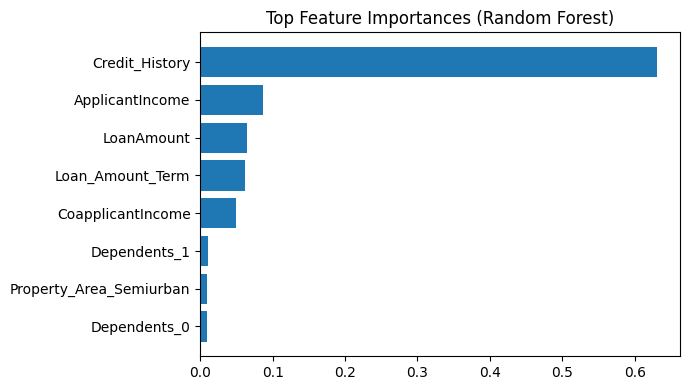

In [18]:
plt.figure(figsize=(7, 4))
topk = fi_df.head(8)
plt.barh(topk["feature"][::-1], topk["importance"][::-1])
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

In [19]:
example = X_test.iloc[[0]]
pred = rf_pipe.predict(example)[0]
proba = rf_pipe.predict_proba(example)[0][1]
print(f"\nExample input:\n{example.to_dict(orient='records')}")
print(f"Predicted synthetic approval: {pred}, probability: {proba:.2f}")


Example input:
[{'Gender': 'Male', 'Married': 'Yes', 'Dependents': '0', 'Education': 'Graduate', 'Self_Employed': 'No', 'ApplicantIncome': 2783, 'CoapplicantIncome': 2708, 'LoanAmount': 158.0, 'Loan_Amount_Term': 360.0, 'Credit_History': 1.0, 'Property_Area': 'Urban'}]
Predicted synthetic approval: 1, probability: 0.98


In [20]:
joblib.dump(rf_pipe, "loan_approval_model_synthetic.pkl")
print("\nSaved pipeline to 'loan_approval_model_synthetic.pkl'")


Saved pipeline to 'loan_approval_model_synthetic.pkl'


In [21]:
import pandas as pd

subset = X_test.iloc[:10].copy()
subset["pred"] = rf_pipe.predict(subset)
subset["approval_prob"] = rf_pipe.predict_proba(subset)[:, 1]
print(subset[["pred", "approval_prob"]].head(10))


     pred  approval_prob
33      1           0.98
123     0           0.20
313     1           0.97
329     0           0.26
186     1           0.94
231     1           0.95
350     1           0.99
132     1           0.95
40      1           0.95
99      0           0.14
